In [ ]:
#data collection
#RAE
import keras
from keras import backend as K
from keras.utils import Sequence
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
from keras import regularizers
from sklearn.linear_model import Lasso

import numpy as np
import scipy.io
np.set_printoptions(precision = 2, suppress = True)
import os
import nibabel as nib
import pandas as pd
from nibabel import cifti2 as ci
from scipy import stats

#subject_num = ["100307", "100408", "101006", "101107", "101309"]
#, "101410", "101915", "102008", "102311", "102816"

path = "/home/qing/Documents/tfMRI_WorkingMemory_preproc/"
dirs = os.listdir(path)

a = np.memmap('sub_WM.mymemmap', dtype = 'float32', mode='w+', shape=(405*791,59421))
del a
sub = np.memmap('sub_WM.mymemmap', dtype='float32', mode='r+', shape=(405*791,59421))
sub_data = np.memmap('sub_WM.mymemmap', dtype='float32', mode='r+', shape=(405*791,59421))

for num1 in range(0,791):
    sub_path =  path + dirs[num1] + "/tfMRI_WM_LR_Atlas_MSMAll.dtseries.nii"
    print(sub_path)
    print(num1)
    img = nib.load(sub_path)
    img = img.get_data()
    
    img = img[:,0:59421]
    print(np.shape(img))
    sub[num1*405:(num1+1)*405, ] = img

print(sub)



In [ ]:
### zscore y#####
import numpy as np
sub = np.memmap('sub_WM.mymemmap', dtype='float32', mode='r+', shape=(405*791,59421))

sub_data = np.memmap('sub_WM.mymemmap', dtype='float32', mode='r+', shape=(405*791,59421))
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
print(np.shape(sub))
img_step = 404 #volumeLength-1
cnt = 0
for num2 in range(0,791*(img_step+1)):
    cnt += 1
    if cnt == (img_step + 1):
        cnt = 0
        sub_data[num2 - img_step: num2 + 1,:] = stats.zscore(sub[num2 - img_step: num2 + 1,:])
        


In [3]:
############## many to many ##########
#RAE
import keras
from keras import backend as K
from keras.models import Sequential, Model
from tensorflow.contrib.keras import layers
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
from keras import regularizers
from sklearn.linear_model import Lasso
sub_data = np.memmap('sub_WM.mymemmap', dtype='float32', mode='r+', shape=(405*791,59421))
print(sub_data)
sub_data1 = sub_data[0:791*(img_step+1),:]
print(np.shape(sub_data1))
data = np.expand_dims(sub_data1, axis=1)
data = np.reshape(data, (791,405 , 59421))
# latent_dim = [320]

input_dim = data.shape[-1] # 13
timesteps =  data.shape[1]# 3

inputs = Input(shape=(timesteps, input_dim,))
layer1 = Dense(128, activation='tanh',activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4))#, activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4)
encoded = layer1(inputs)
encoded = LSTM(64,return_sequences=True,activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4))(encoded)#
encoded = LSTM(32,return_sequences=True,activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4))(encoded)#, activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4)

encoder = Model(inputs, encoded)
encoder.summary()

inputs = Input(shape=(timesteps, 32,))
decoded = LSTM(64, return_sequences=True,activation='tanh')(inputs)
decoded = LSTM(128, return_sequences=True,activation='tanh')(decoded)
outputs = Dense(input_dim, activation='tanh')(decoded)


decoder = Model(inputs, outputs)
decoder.summary()
# model for RAE
inputs = Input(shape=(timesteps, input_dim,))
outputs = encoder(inputs)
outputs = decoder(outputs)
sequence_autoencoder = Model(inputs, outputs)

# autoencoder = Model(inputs, decoded)

sequence_autoencoder.compile(optimizer='adam', loss='mse')
sequence_autoencoder.summary()
sequence_autoencoder.fit(data, data, epochs=10, batch_size =1)




[[-0.02616589  3.0593698  -1.0705769  ...  0.7143601   0.5465671
   0.87927294]
 [ 0.90839887  0.7510723  -0.16736045 ...  0.64683974 -0.34913963
  -0.09231295]
 [ 0.48167205 -0.15090463 -0.83436763 ...  0.573333    0.36275938
   0.82289046]
 ...
 [-0.09681635  0.8451742  -0.9983279  ...  0.33905798  0.24529329
   0.08418003]
 [-0.5779838  -0.18148853 -0.05537398 ...  0.16323632 -0.9087682
   0.98800457]
 [-0.95193547 -0.26276356 -0.7311124  ...  0.1967955   0.45013475
  -0.62865144]]
(320355, 59421)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 405, 59421)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 405, 128)          7606016   
_________________________________________________________________
lstm_1 (LSTM)                (None, 405, 64)           49408     
________________________________

In [4]:
#### predict hidden layer ###

y = np.zeros((791,405,32), dtype=float)
for i in range(0,791):
    y[i * 1 : (i + 1) * 1]=encoder.predict(data[i * 1 : (i + 1) * 1])
    
print(y)

[[[ 3.33939344e-02  1.69017084e-03 -6.85325451e-03 ...  4.97603323e-03
   -5.88189475e-02  3.06592304e-02]
  [ 2.14406196e-02  1.51764823e-03  2.22539157e-03 ...  4.01427131e-03
   -6.58761933e-02  3.14336568e-02]
  [ 1.20540503e-02  8.91738688e-04  6.41455315e-03 ...  2.35709897e-03
   -6.43837303e-02  2.23162435e-02]
  ...
  [-4.73846123e-03 -6.90584420e-04  4.50769765e-03 ... -1.00211939e-03
   -2.00485904e-02  1.32403307e-04]
  [-7.26173166e-03 -1.10109418e-03  4.13449155e-03 ... -2.08657305e-03
   -1.03313355e-02 -4.49387589e-03]
  [-4.13233502e-04 -1.05328299e-03  3.12642381e-03 ... -3.31072370e-03
   -2.30283234e-02 -2.28351145e-03]]

 [[ 3.22997868e-02  1.75032998e-03 -9.10837855e-03 ...  7.02728191e-03
   -4.71539497e-02  3.12831551e-02]
  [ 2.91477293e-02  1.65427255e-03 -2.95112375e-03 ...  6.36080047e-03
   -6.06659800e-02  3.81053686e-02]
  [ 2.69233715e-02  1.46453234e-03  7.47888931e-04 ...  5.38519816e-03
   -7.51175806e-02  3.57766636e-02]
  ...
  [-5.59165049e-03 -7.2

(791, 405, 32)


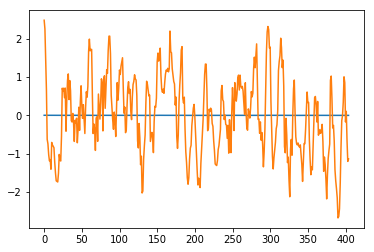

In [5]:
### zscore y#####
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
print(y.shape)
y = np.reshape(y, (791*405, 1, 32))
t = range(0, 405)
plt.plot(t, y[405*0: 405*1, 0,1])
y_norm = np.zeros((405*791, 1,32), dtype=float)
img_step = 404
cnt = 0
for num2 in range(np.shape(y)[0]):
    cnt += 1
    if cnt == (img_step + 1):
        cnt = 0
        y_norm[num2 - img_step: num2 + 1,:] = stats.zscore(y[num2 - img_step : num2 + 1,:])
        

where_are_NaNs = isnan(y_norm)
y_norm[where_are_NaNs] = 0
plt.plot(t, y_norm[405*0: 405*1, 0,1])

In [43]:
print(np.shape(task_content))

(316, 3)


In [29]:
print(np.shape(task_content))

(405, 10)


0.403


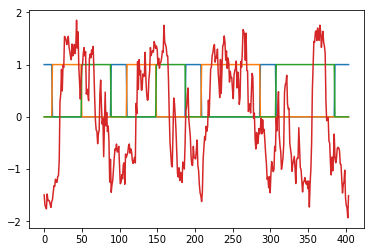

In [48]:
###plot task_cope and y_norm#####
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
t = range(0, 405)
task = sio.loadmat('/home/qing/Documents/HCP_Label/WM_label1.mat')
task_content = task['Label']

y_WM = sio.loadmat('/home/qing/PycharmProjects/RAE/WM_y_norm_20190206.mat')
y_norm = y_WM['y_norm']

plt.plot(t,task_content[:,8])
plt.plot(t,task_content[:,3])
plt.plot(t,task_content[:,4])

plt.plot(t, y_norm[405*4:405*5, 0,30])##0##for new, there is three dimension
my_y_ticks = np.arange(-2, 3, 1)
plt.yticks(my_y_ticks)
temp = np.corrcoef(task_content[:,3],y_norm[405*4:405*5,0,30])
print('%.3f' % temp[0,1]) 

In [392]:
corr_value = np.zeros((32),dtype = float)
for i in range(0, 32):
    a = task_content[:,4]
    b = y_norm[405*4:405*(4+1),0,i]
    temp=np.corrcoef(a,b)
    corr_value[i] = temp[0,1]
print(corr_value)

[-0.01  0.07  0.24 -0.2   0.11  0.06  0.1  -0.25 -0.11 -0.19 -0.21  0.14
 -0.16 -0.19  0.    0.21  0.23 -0.19  0.01 -0.04  0.06  0.21 -0.19  0.15
 -0.02  0.11 -0.15  0.08  0.1   0.13 -0.09 -0.19]


In [393]:
indices = np.where(corr_value == corr_value.max())
print(indices[0])

[2]


In [8]:
import scipy.io as sio
sio.savemat('WM_y_norm_20190206.mat', {'y_norm':y_norm})  
  

In [18]:
#### correlation matrix of networks and volumes ###
import numpy as np
import scipy.io as sio
sub_data = np.memmap('sub_WM.mymemmap', dtype='float32', mode='r+', shape=(405*791,59421))

task = sio.loadmat('/home/qing/PycharmProjects/RAE/WMcomponents_img_avg_norm1.mat')
components_img_norm = task['components_img_avg_norm']

corr_net = np.zeros((791, 405, 32), dtype=float)
for i in range(549, 550):
    a = sub_data[i * 405 : (i + 1) * 405, :]
    for k in range(0, 405):
        c = a[k, :]
        for j in range(0, 32):
            b = components_img_norm[j, :]
            temp=np.corrcoef(c,b)
            corr_net[i,k,j] = temp[0,1]#i:subnumber k:timepoint of one sub j:networknumber


In [176]:
print(np.shape(corr_net))
corr_net_norm = np.zeros((791,316,32),dtype = float)
for num2 in range(np.shape(corr_net)[0]):
    corr_net_norm[num2,:] = stats.zscore(corr_net[num2,:])
        


where_are_NaNs= isnan(corr_net_norm)
corr_net_norm[where_are_NaNs] = 0

(791, 316, 32)


In [21]:
print(np.max(corr_net[549,:,:]))

0.3699509133525879


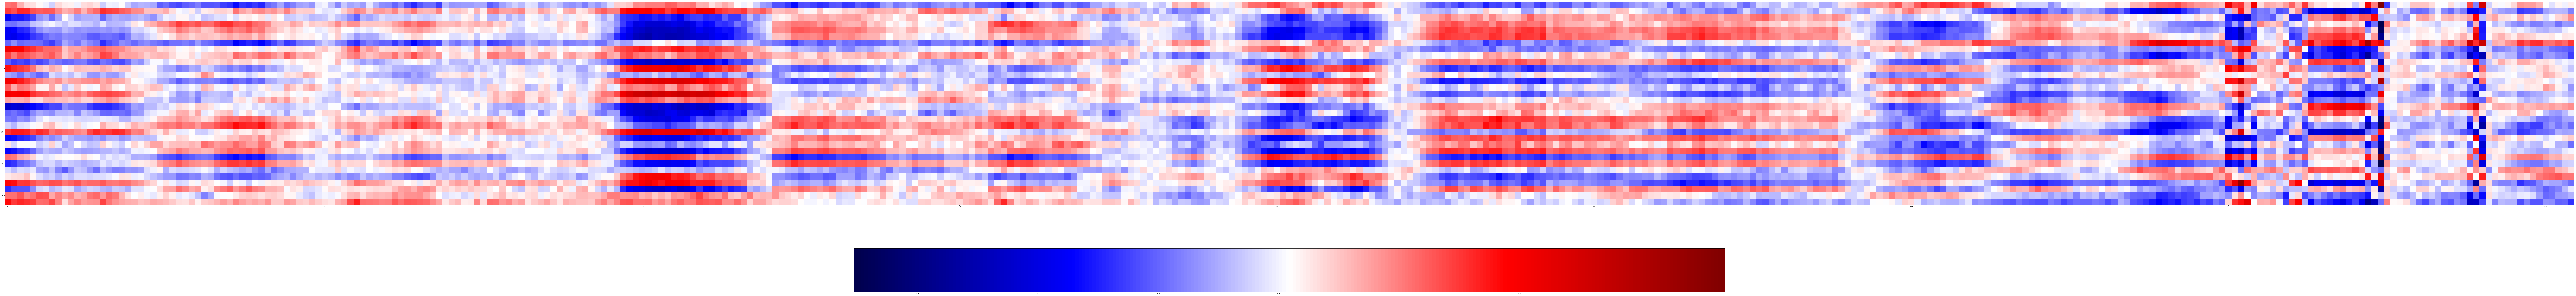

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(405, 32))
a = np.transpose(corr_net[549,:,:])
im = ax.imshow(a, cmap = 'seismic', interpolation='nearest',origin='upper')
fig.colorbar(im, orientation = 'horizontal')

In [30]:
#calculate the correlation of the GLM with the components
dataFile1 = '/home/qing/PycharmProjects/RAE/WMcomponents_img_avg_norm1.mat'
WM1 = sio.loadmat(dataFile1)
WM1 = WM1['components_img_avg_norm']

dataFile2 = '/home/qing/PycharmProjects/RAE/WM_components_img_GLM_norm.mat'
WM2 = sio.loadmat(dataFile2)
WM2 = WM2['components_img_GLM_avg_norm']

corr_map = np.corrcoef(WM1[4,:],WM2[9,:])
print(corr_map)

[[1.         0.89249179]
 [0.89249179 1.        ]]


In [4]:
##### fit networks by ElasticNet ####
import numpy as np
import scipy.io as sio
from sklearn.linear_model import ElasticNet
sub_data = np.memmap('sub_WM.mymemmap', dtype='float32', mode='r+', shape=(405*791,59421))

y = sio.loadmat('/home/qing/PycharmProjects/RAE/WM_y_norm_20190206.mat')
y_norm = y['y_norm']
y1 = np.squeeze(y_norm)

clf = ElasticNet(alpha=0.7, l1_ratio=0.005)
components_img = np.zeros((791,32, 59421), dtype = float)

for i in range(0,791):
    
    a=y1[i * 405 : (i + 1) * 405, :]
    b=sub_data[i * 405 : (i + 1) * 405, :]
    clf.fit(a, b)
    components_img[i,:,:] = np.transpose(clf.coef_)



In [5]:
components_img_avg = np.zeros((32,59421),dtype = float)
for i in range(0,59421):
    components_img_avg[:,i] = np.mean(components_img[:,:,i],axis = 0)


In [6]:
### zscore y#####
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
components_img_avg_norm = np.zeros((32,59421),dtype = float)
# print(components_img_GLM.shape)
for num2 in range(0,np.shape(components_img_avg)[0]):
    components_img_avg_norm[num2,:] = stats.zscore(components_img_avg[num2,:])
        


where_are_NaNs= isnan(components_img_avg_norm)
components_img_avg_norm[where_are_NaNs] = 0


In [8]:
import scipy.io as sio
sio.savemat('WMcomponents_img_avg_norm2.mat', {'components_img_avg_norm':components_img_avg_norm})  
  

In [9]:
#### save patterns####
import nibabel as nib
import pandas as pd
from nibabel import cifti2 as ci


image = nib.load('/home/qing/Documents/tfMRI_Emotion_preproc/100307_3T_tfMRI_EMOTION_preproc/tfMRI_EMOTION_LR_Atlas_MSMAll1.dtseries.nii')
header = image.header
print(header)  
print(np.shape(image.get_data()))
#print(image.nifti_header.get_data_shape())
#image.update_headers()

image_to_write = image.get_data()
image_to_write[:, :] = 0
image_to_write[:32, :59421] = components_img_avg_norm

print(np.shape(image_to_write))
#print(image.nifti_header.get_data_shape())
#print(header)
write_img = ci.Cifti2Image(image_to_write, image.header, image.nifti_header)
nib.save(write_img, 'test_WM_791sub_LSTM_GLM_norm_avg2.dtseries.nii')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(176, 91282)
(176, 91282)


In [334]:
from sklearn.linear_model import ElasticNet
import scipy.io as sio
t = range(0, 405)
task = sio.loadmat('/home/qing/Documents/HCP_Label/WM_label1.mat')
task_content = task['Label']

clf_GLM = ElasticNet(alpha=0.7, l1_ratio=0.005)
components_img_GLM = np.zeros((791,10, 59421), dtype = float)

for i in range(0,791):
    
    a=task_content[:,0:10]
    b=sub_data[i * 405 : (i + 1) * 405, :]
    clf_GLM.fit(a, b)
    components_img_GLM[i,:,:] = np.transpose(clf_GLM.coef_)
 

In [339]:
components_img_GLM_avg = np.zeros((10,59421),dtype = float)
for i in range(0,59421):
    components_img_GLM_avg[:,i] = np.mean(components_img_GLM[:,:,i],axis = 0)
### zscore y#####
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
components_img_GLM_avg_norm = np.zeros((10,59421),dtype = float)
# print(components_img_GLM.shape)
for num2 in range(0,np.shape(components_img_GLM_avg)[0]):
    components_img_GLM_avg_norm[num2,:] = stats.zscore(components_img_GLM_avg[num2,:])

where_are_NaNs= isnan(components_img_GLM_avg_norm)
components_img_GLM_avg_norm[where_are_NaNs] = 0
import scipy.io as sio
sio.savemat('WM_components_img_GLM_norm.mat', {'components_img_GLM_avg_norm':components_img_GLM_avg_norm})  
  

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [38]:
####calculate the correlation of two times trials####

import scipy.io as scio
import numpy as np
dataFile1 = '/home/qing/PycharmProjects/RAE/WMcomponents_img_avg_norm1.mat'
WM1 = scio.loadmat(dataFile1)
WM1 = WMe1['components_img_avg_norm']

dataFile2 = '/home/qing/PycharmProjects/RAE/WMcomponents_img_avg_norm2.mat'
WM2 = scio.loadmat(dataFile2)
WM2 = WM2['components_img_avg_norm']

sum_1 = sum(WM1[4,:])
sum_2 = sum(WM2[0,:])
print(sum_2/sum_1)
corr_network = np.corrcoef(WM1[4,:],WM2[0:])
print('%.3f' % corr_network[0,1])

-0.6908555105610813
-0.802


In [187]:
print(np.shape(Language1))

(32, 59421)
